In [1]:
import pandas, numpy, seaborn, umap
import scipy, scipy.signal
import sklearn, sklearn.cluster
import MulticoreTSNE

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

# user-defined variables

In [ ]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [3]:
path = input_file_directory + "xenabrowser_brut_data/"
path2 = output_file_directory + "/dataframes_for_input/"

In [4]:
iso1 = 'ENST00000354449.7'
iso2 = 'ENST00000354956.9'

# read data

In [5]:
%%time
selected_expression = pandas.read_csv(expression_file, index_col=0, sep='\t')
print(selected_expression.shape)
selected_expression.head()

(46490, 4385)
CPU times: user 29 s, sys: 1.09 s, total: 30.1 s
Wall time: 30.1 s


,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-P44H-0526-SM-2XCF1,GTEX-11ONC-2326-SM-5HL6P,...,GTEX-144GO-0126-SM-5LUAO,GTEX-1313W-1626-SM-5J1OE,GTEX-12ZZY-1526-SM-5LZWF,GTEX-QMRM-0826-SM-3NB33,GTEX-OOBK-2626-SM-2HMKY,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-ZA64-2126-SM-5Q5A8,GTEX-Q2AG-2826-SM-2HMJQ,GTEX-XV7Q-0426-SM-4BRVN
sample,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,2.172597,2.098120,0.604361,1.012243,2.112940,1.282651,2.350597,1.055977,2.652690,2.268121,...,0.979851,2.130198,1.992097,1.513298,1.761416,2.140628,2.460868,1.539885,3.384828,2.148756e+00
ENST00000583693.5,1.679476,1.659720,2.343766,2.182024,1.608522,2.342481,1.919266,2.462014,1.794654,1.688779,...,2.027438,1.520067,1.725912,2.402364,2.313324,1.886362,3.031236,2.084875,3.180704,1.991199e+00
ENST00000012134.6,0.028054,1.528813,1.308149,0.799196,2.200149,1.650502,1.646210,2.311007,1.437005,2.369605,...,1.576889,1.827558,2.260518,1.542512,2.087475,1.687606,1.888114,1.929434,3.288411,1.385126e+00
ENST00000403263.5,2.737514,2.433423,2.221165,2.084570,2.304542,2.238873,2.688859,2.615937,3.291015,2.220693,...,2.220222,2.060171,2.130275,2.778681,1.937410,2.314922,2.136376,2.615435,2.532466,1.944068e+00
ENST00000449352.6,1.695411,2.800497,2.215746,2.359610,2.831991,2.112632,2.839560,2.607822,1.759019,2.999159,...,3.785498,1.353480,2.671217,2.489579,1.660130,1.744530,3.022813,2.252766,1.301894,8.428712e-08


# quantile normalization

In [6]:
%%time
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(selected_expression.values, axis=0), index=selected_expression.index, columns=selected_expression.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = selected_expression.rank(method="min").stack().astype(int).map(df_mean).unstack()

CPU times: user 1min, sys: 6.19 s, total: 1min 6s
Wall time: 1min 6s


14.553924904476192
4385


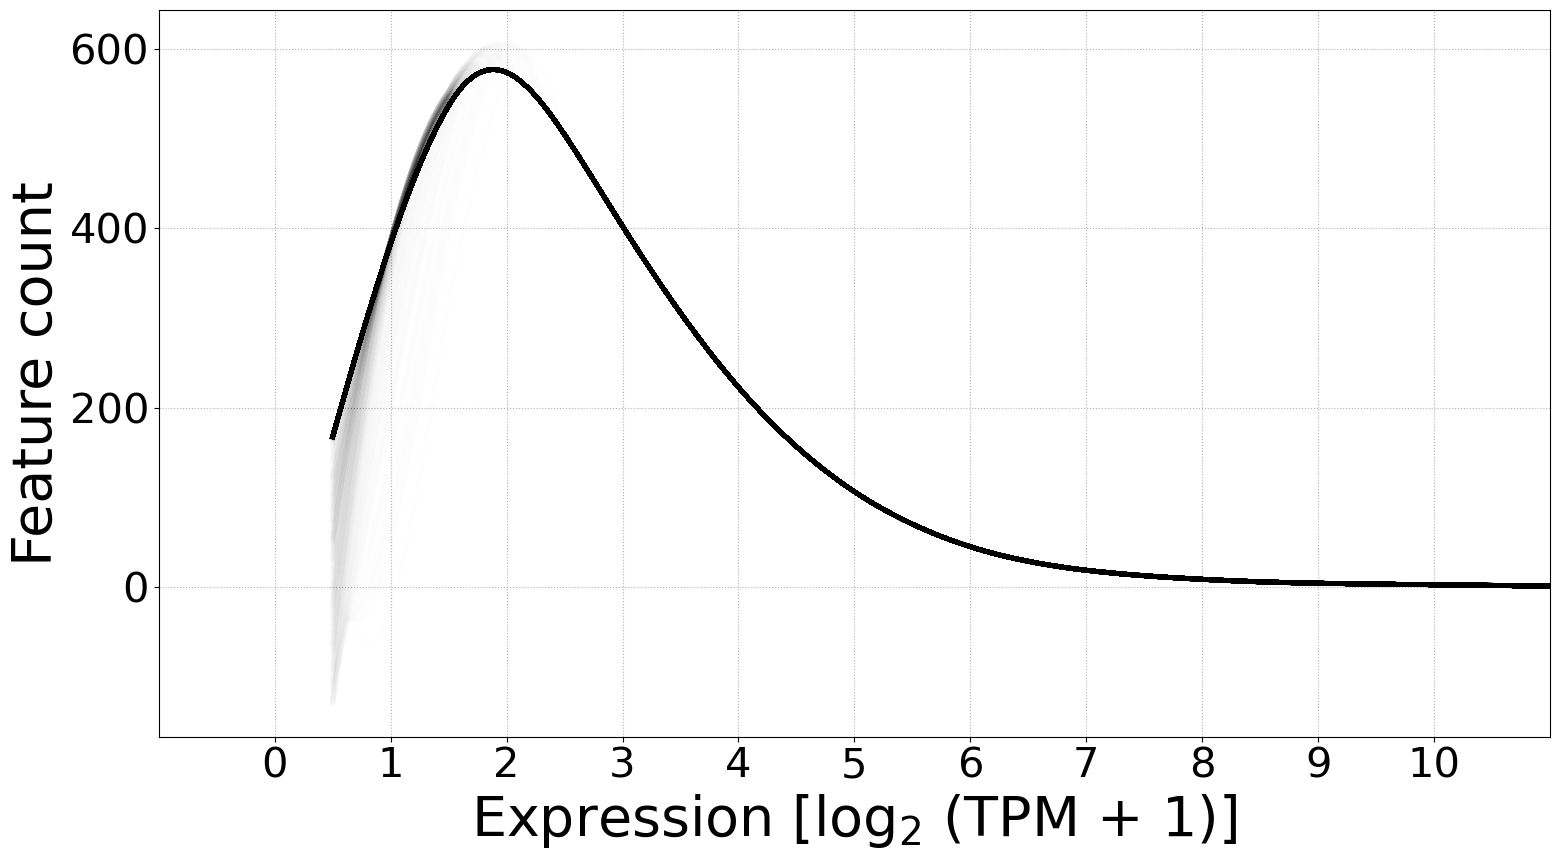

In [7]:
found_max = 15
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/2)

most_likely_expressions = []

selected_samples = []

for sample in qndf.columns:
        
    expression_values = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # determine most likely expression
    most_likely_expression = x[numpy.argmax(yhat)]
    most_likely_expressions.append(most_likely_expression)
    
    # sample selection
    if 1 <= most_likely_expression <= 2:
        selected_samples.append(sample)
    
    # plotting
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='black')
    
    # check
    if numpy.max(expression_values) > absolute_max:
        absolute_max = numpy.max(expression_values)

# check print
print(absolute_max)
print(len(selected_samples))

matplotlib.pyplot.xlim(-1, 11)                  
matplotlib.pyplot.xticks(range(0, 10+1))
matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [8]:
%%time
tqndf = qndf.transpose()
tqndf.to_csv('{}/tqndf.tsv'.format(output_dir), sep='\t')

CPU times: user 3min 45s, sys: 1.6 s, total: 3min 46s
Wall time: 3min 47s


# z-score

In [9]:
zscore_df = scipy.stats.zscore(qndf, axis=1)
zscore_df.std(axis=1)

sample
ENST00000625998.2    1.000114
ENST00000583693.5    1.000114
ENST00000012134.6    1.000114
ENST00000403263.5    1.000114
ENST00000449352.6    1.000114
                       ...   
ENST00000470412.5    1.000114
ENST00000469534.1    1.000114
ENST00000507412.1    1.000114
ENST00000568351.1    1.000114
ENST00000491408.1    1.000114
Length: 46490, dtype: float64

In [10]:
print(zscore_df.max().max())
print(zscore_df.min().min())

15.804689630376652
-18.18179087330121


In [11]:
%%time
zscore_df.to_csv('{}/zscore.tsv'.format(output_dir), sep='\t')

CPU times: user 2min 25s, sys: 1.7 s, total: 2min 27s
Wall time: 2min 27s
